In [1]:
import numpy as np
from collections import Counter, defaultdict, namedtuple
from math import gcd, ceil
import re
import networkx as nx
from dataclasses import dataclass
from matplotlib import pyplot as plt
# plt.imshow(pic)
from functools    import cache

from aocutils.common import to_int, flatten, reverse_dict, zippify, list_multiply, ints
from aocutils.grid import iterate, arr_to_dict, grid_to_dict, neighbors, arr_neighbors, dimensions, manhattan, positive, conv1d, conv2d
from aocutils.maze import bfs, dijkstra, get_path, dfs
from aocutils.math import lcm, gcd, factors, mul_inv
from aocutils.special import find_pattern_in_iter, find_repeat, find_cycle, md5, CFG, ShuntingYard, binarysearch, deduce_matches
from aocutils.visuals import visualize_graph, labelize, cat, animate_grid

(0,
 ((2, 7),
  (3, 9),
  (4, 7),
  (5, 9),
  (2, 9),
  (3, 7),
  (4, 5),
  (5, 7),
  (2, 3),
  (2, 5),
  (3, 5),
  (4, 9),
  (3, 3),
  (4, 3),
  (5, 3),
  (5, 5)))

[(2, 3), (2, 4), (2, 5), (2, 6), (1, 6)]

In [54]:
paths[((2, 3), (1, 6))]

{(1, 3), (1, 4), (1, 5)}

In [200]:
lines = open('test0.txt').read().splitlines()
lines = [to_int(list(line)) for line in lines]
neigh = arr_neighbors(lines)
maze = grid_to_dict(lines)
conn = {}
A = []
B = []
C = []
D = []
spaces = set()
for k,v in maze.items():
    if v != ' ' and v != '#':
        conn[k] = {n for n in neigh[k] if maze[n]!=' ' and maze[n] != '#'}
        spaces.add(k)
    if v == 'A':
        A.append(k)
    if v == 'B':
        B.append(k)
    if v == 'C':
        C.append(k)
    if v == 'D':
        D.append(k)
locs = tuple(sorted(A) + sorted(B) + sorted(C) + sorted(D))
state = 0, locs
paths = {}
for i in spaces:
    for j in spaces:
        if i != j:
            paths[i,j] = set(bfs(conn, i,j)[1:-1])
# start and end are included in paths
def goal_reached(locs):
    if [l[1] for l in locs] == [3,3,3,3,5,5,5,5,7,7,7,7,9,9,9,9]:
        return True
    return False
    

costs = {0:1, 1:1, 2:1,3:1, 4:10, 5:10, 6:10, 7:10, 8:0, 9:0,10:0,11:0,12:0,13:0,14:0, 15:0}
costs = {0:1, 1:1, 2:1,3:1, 4:10, 5:10, 6:10, 7:10, 8:100, 9:100,10:100,11:100,12:1000,13:1000,14:1000, 15:1000}
target = {0:3, 1:3, 2:3,3:3, 4:5, 5:5, 6:5, 7:5, 8:7, 9:7,10:7,11:7,12:9,13:9,14:9, 15:9}
import heapq

def getnext(state):
    options = []
    cost, locs = state
    locs = list(locs)
    taken = set(locs)
    free = spaces - taken
    nextgoal = defaultdict(int)
    # print(free)
    filleduntil = {}
    for col in (3,5,7,9):
        filleduntil[col] = 0
        for row in (5,4,3,2):
            if (row,col) in free:
                nextgoal[col] = row, col
                break
            occupied = locs.index((row,col))
            
            if target[occupied] != col:
                break
            else:
                filleduntil[col] = row
    # print(nextgoal)
                
    for idx, o in enumerate(locs):
        # if o == (2,3): print('hi')
        targetcol = target[idx]
        goal = nextgoal[targetcol]
        if goal and o[1] == targetcol and o[0] > goal[0]:
            # already at location
            continue
        if o[1] == targetcol and o[0]<=filleduntil[targetcol]:
            continue
        else:
            if goal:
                path = paths[o, goal]
                if path == path & free:
                    newcost = costs[idx] * (len(path) + 1) + cost
                    newlocs = locs.copy()
                    newlocs[idx] = nextgoal[targetcol]
                    newlocs = tuple(newlocs)
                    options.append(tuple([newcost, newlocs]))
                    continue
                
            #no goal atm or path to goal is blocked
            # if o == (2,9):print(o,targetcol)
            if o[0] != 1:
                # we are not at first row and target is not same col (so in wrong column)
                for f in free:
                    if f[0] == 1 and not f[1] in (3,5,7,9):
                        # we want to move to first row
                        if not f[1] == o[1]:
                            # but not if column is the same 
                            path = paths[o, f]
                            if path == path & free:
                                newcost = costs[idx] * (len(path) + 1) + cost
                                newlocs = locs.copy()
                                newlocs[idx] = f
                                newlocs = tuple(newlocs)
                                options.append(tuple([newcost, newlocs]))
                                # print(o)
    return options
res = getnext(state)
len(res)

28

In [201]:
#############
#...........#
###C#C#A#B###
  #D#C#B#A#  
  #D#B#A#C#  
  #D#D#B#A#  
  #########  

In [202]:
goal_reached([(3,3),(3,3),(3,3),(3,3),(5,5),(5,5),(5,5),(5,5),(7,7),(7,7),(7,7),(1,7),(9,9),(9,9),(9,9),(1,9)])

True

In [203]:
#export
def dijkstra(connections,start, goal=None):
    """
    Requires a dict with as values a LIST of tuples (neighbor, weight)
    Or a function returning a list of tuples with neighbors and weights per node

    Returns
    if goal == None:    return all paths from start
    elif goal found:    returns path to goal
    else:               returns False
    """
    seen = set() # the locations that have been explored
    
    frontier = [start] # the locations that still need to be visited
    parents = {start[0]: (None,0)}

    def get_path(parents):
        cur = goal
        path = [cur]
        cost = parents[cur][1]
        while cur != start:
            cur = parents[cur][0]
            path.append(cur)
        path.reverse()
        return path,cost
    i = 0
    while frontier:
        i += 1
        # print(parents)
        # print(len(frontier))
        # print('\n\n',frontier,'\n',parents)
        new = heapq.heappop(frontier)
        
        search_cost, search_node = new
        if i % 30000 == 0:
            print(len(frontier), search_cost)

        if goal(search_node): 
            print('goal found')
            print(search_cost, search_node)
            return search_cost, search_node, parents
        neighbors = connections(new)
        # print('neigh', len(neighbors), neighbors)
        if neighbors:
            for n in neighbors:
                
                # print(n)
                newcost, newlocs = n


                if newlocs not in seen:
                    # print('n',n)
                    if newlocs not in parents or newcost < parents[newlocs][1]:
                        # print('updating')
                        heapq.heappush(frontier,(newcost, newlocs))
                        # paths[n] = paths[search_node]+[n]
                        parents[newlocs]= search_node,newcost
                            # return paths[goal],parents
        seen.add(search_node)
    
    if not goal: return parents
    elif goal in parents: return get_path(search_node)
    else: return False
search_cost, search_node, parents = dijkstra(getnext, state, goal_reached)
# search_cost
# dijkstra(getnext, state, goal_reached)


20502 875
27591 1318
31029 1946
19437 5263
16377 7451
15066 10048
10463 14270
goal found
50132 ((2, 3), (3, 3), (4, 3), (5, 3), (2, 5), (3, 5), (5, 5), (4, 5), (2, 7), (5, 7), (4, 7), (3, 7), (4, 9), (3, 9), (2, 9), (5, 9))


In [177]:
cur = search_node
path = [cur]
cost = parents[cur][1]
while cur != state[1]:
    cur = parents[cur][0]
    path.append(cur)
path.reverse()

In [ ]:
cur = search_node
path = [cur]
cost = parents[cur][1]
while cur != state[1]:
    cur = parents[cur][0]
    path.append(cur)
path.reverse()

In [185]:
search_cost

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 10,
 5: 10,
 6: 10,
 7: 10,
 8: 100,
 9: 100,
 10: 100,
 11: 100,
 12: 1000,
 13: 1000,
 14: 1000,
 15: 1000}

In [194]:

cost = 0
for step, (x,y) in enumerate(zip(path, path[1:])):
    for i in range(16):
        if x[i]!=y[i]:
            steps = len(paths[x[i], y[i]])+1
            cost += costs[i]* steps
            print(step, i, costs[i], x[i],y[i])
print(cost)

0 12 1000 (2, 9) (1, 11)
1 0 1 (3, 9) (1, 1)
2 5 10 (2, 7) (1, 9)
3 6 10 (3, 7) (1, 8)
4 1 1 (4, 7) (1, 2)
5 8 100 (2, 5) (4, 7)
6 9 100 (3, 5) (3, 7)
7 7 10 (4, 5) (1, 6)
8 15 1000 (5, 5) (1, 4)
9 7 10 (1, 6) (5, 5)
10 6 10 (1, 8) (4, 5)
11 5 10 (1, 9) (3, 5)
12 10 100 (4, 9) (2, 7)
13 3 1 (5, 9) (1, 10)
14 15 1000 (1, 4) (5, 9)
15 4 10 (2, 3) (2, 5)
16 13 1000 (3, 3) (4, 9)
17 14 1000 (4, 3) (3, 9)
18 3 1 (1, 10) (4, 3)
19 1 1 (1, 2) (3, 3)
20 0 1 (1, 1) (2, 3)
21 12 1000 (1, 11) (2, 9)
44149


In [184]:
cost

6376

In [186]:
path

[((3, 9),
  (4, 7),
  (5, 3),
  (5, 9),
  (2, 3),
  (2, 7),
  (3, 7),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (2, 9),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((3, 9),
  (4, 7),
  (5, 3),
  (5, 9),
  (2, 3),
  (2, 7),
  (3, 7),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (1, 11),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((1, 1),
  (4, 7),
  (5, 3),
  (5, 9),
  (2, 3),
  (2, 7),
  (3, 7),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (1, 11),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((1, 1),
  (4, 7),
  (5, 3),
  (5, 9),
  (2, 3),
  (1, 9),
  (3, 7),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (1, 11),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((1, 1),
  (4, 7),
  (5, 3),
  (5, 9),
  (2, 3),
  (1, 9),
  (1, 8),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (1, 11),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((1, 1),
  (1, 2),
  (5, 3),
  (5, 9),
  (2, 3),
  (1, 9),
  (1, 8),
  (4, 5),
  (2, 5),
  (3, 5),
  (4, 9),
  (5, 7),
  (1, 11),
  (3, 3),
  (4, 3),
  (5, 5)),
 ((1, 1),
  (1, 2),
  (5, 3),

In [68]:
getnext((((2, 7), (3, 9), (2, 9), (3, 7), (2, 3), (2, 5), (3, 3), (3, 5)), 0))

((2, 7), (3, 9), (2, 9), (3, 7), (2, 3), (2, 5), (3, 3), (3, 5))


[((1, 7), (3, 9), (2, 9), (3, 7), (2, 3), (2, 5), (3, 3), (3, 5), 1),
 ((2, 7), (3, 9), (1, 9), (3, 7), (2, 3), (2, 5), (3, 3), (3, 5), 10),
 ((2, 7), (3, 9), (2, 9), (3, 7), (1, 3), (2, 5), (3, 3), (3, 5), 100),
 ((2, 7), (3, 9), (2, 9), (3, 7), (2, 3), (1, 5), (3, 3), (3, 5), 100)]

In [3]:
reg, lines = open('input.txt').read().split('\n\n')
lines = [to_int(line.split()) for line in lines.splitlines()]

In [4]:
ins = lines
labels = {idx: tuple(i) for idx, i in enumerate(ins)}
viz = set()

reg = {'a': 0, 'b':0}
pnt = 0

n_steps = 3
for i in range(n_steps):
    prev = pnt
    match ins[pnt]:
        
        case 'jie', register, toadd:
            reg[register] += toadd
        case 'jmp', register:
            reg[register] = 10
        case 'jmp', register, toadd:
            reg[register] += toadd
    pnt += 1
    viz.add((prev, pnt))
            

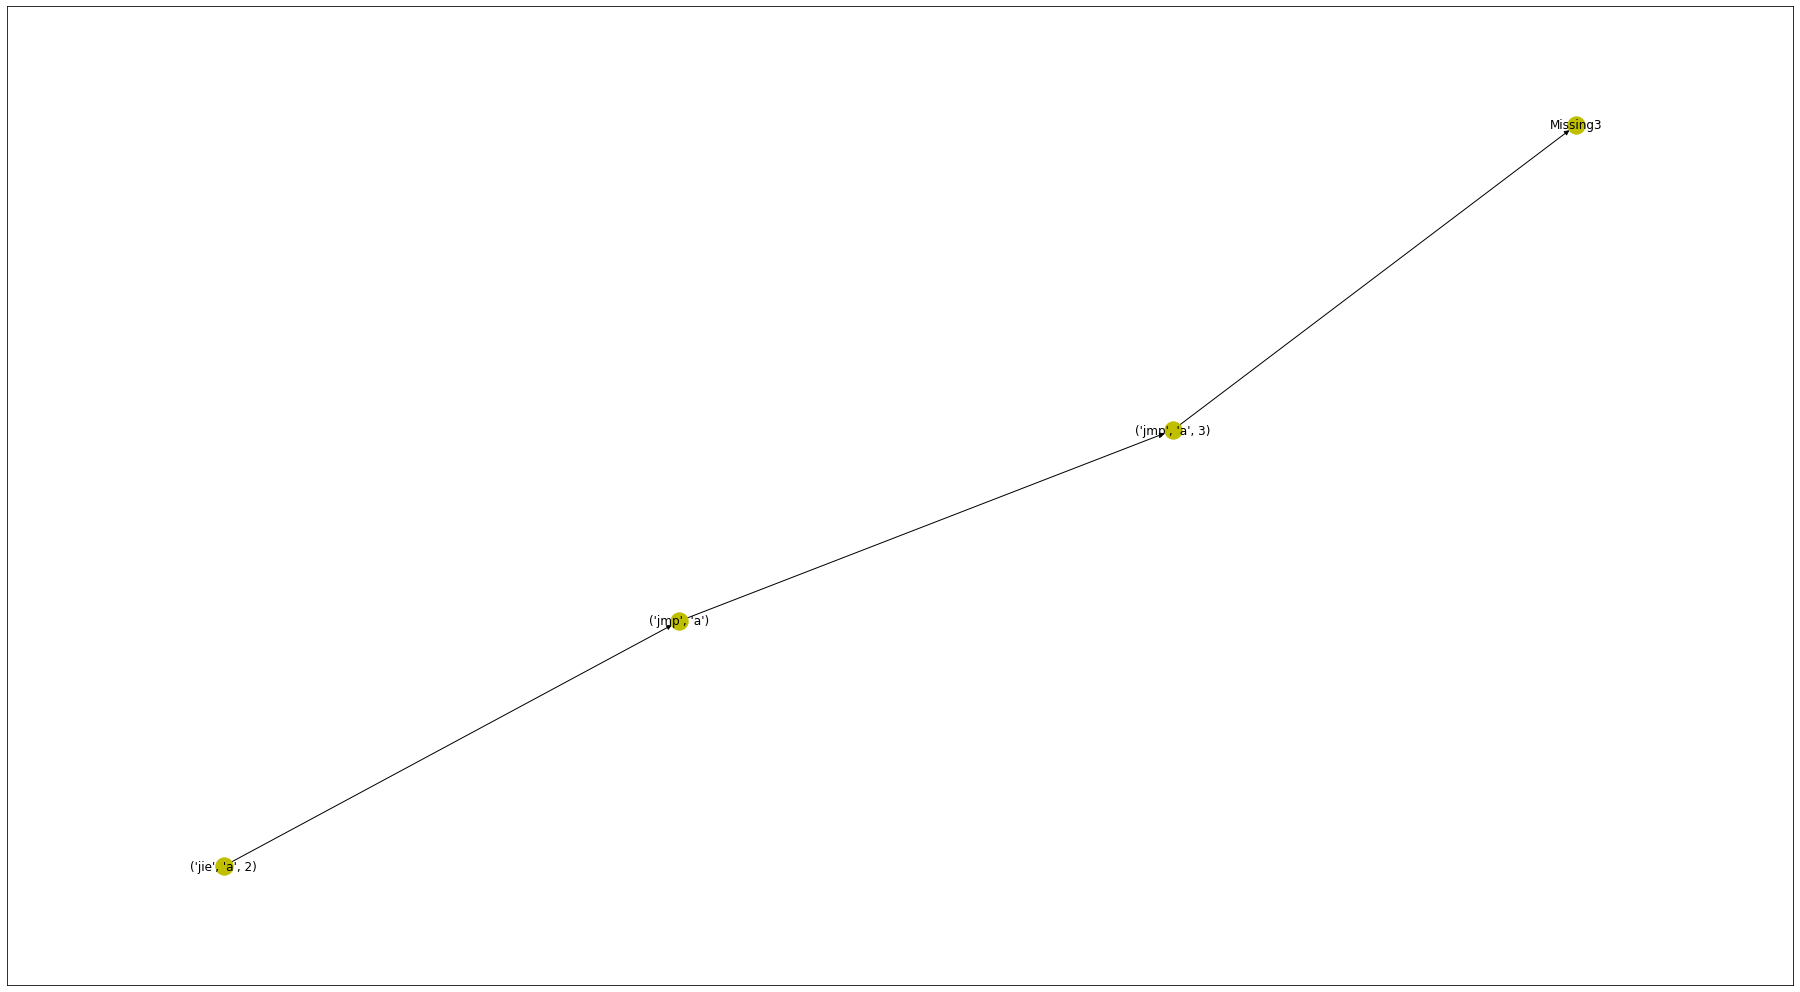

In [5]:
visualize_graph(viz, labels)